# 1. Descrição dos dados

Colunas | Descrições
-------|----------
Store | ID exclusivo de cada loja
DayOfWeek | Dia da semana em que a venda ocorreu
Date | Data de venda
Sales | Vendas por dia
Customers | Nº de clientes por dia
Open | Indicador para loja aberta: 0 = fechado, 1 = aberto
Promo |Indica a loja está realizando promoção no dia
StateHoliday |Indica um feriado: a = feriado público, b = Páscoa, c = Natal, 0 = nenhum
SchoolHoliday | Indica se a loja foi ou não fechada durante o feriado escolar
StoreType | Diferencia em 4 modelos de lojas diferentes: a, b, c, d
Assortment | Indica o nível de variedade de produtos: a = básico, b = extra, c = estendido
CompetitionDistance | Distância em metros até a loja concorrente mais próxima
CompetitionOpenSinceMonth | Fornece o mês aproximado em que o concorrente mais próximo foi aberto
CompetitionOpenSinceYear' | Fornece o ano aproximado em que o concorrente mais próximo foi aberto
Promo | Indica se a loja está com alguma promoção ativa no dia
Promo2 |Indica se a loja deu continuidade na promoção: 0 = loja não está participando, 1 = loja participando
Promo2SinceWeek | Descreve a semana em que a loja começou a participar da Promo2
Promo2SinceYear | Descreve o ano em que a loja começou a participar da Promo2
PromoInterval | Meses em que a Promo2 ficou ativa

# 2. Bibliotecas

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from IPython.display import Image
import datetime
from tabulate import tabulate
import inflection

import math
from scipy import stats as stats

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import datetime

# 3. Funções auxiliares

In [2]:
# Cramer V para calcular a correlação de dados categóricos

def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y).to_numpy()
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape

    chi2 = stats.chi2_contingency(confusion_matrix)[0]

    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2/n)/(min(k-1, r-1)))

# função para reduzir o tamanho do dataset


def change_dtype(dataset):
    dataset[dataset.select_dtypes(np.float64).columns] = dataset.select_dtypes(
        np.float64).astype(np.float32)
    dataset[dataset.select_dtypes(np.int64).columns] = dataset.select_dtypes(
        np.int64).astype(np.int32)


# função que recebe o nome do modelo, o y_teste e y_pred

def ml_error(model_name, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return pd.DataFrame([{'Model': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}], index=[0])

# função para calcular o MPE (mean percentage error):

def mean_percentage_error(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

# 4. Carregamento dos dados

In [3]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

# merge (unindo os arquivos csv)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
# diminuindo tamanho do dataset

change_dtype(df_raw)

# 5. Descrição dos dados

## 5.1 Renomeando colunas

In [5]:
# criando uma cópia do dataset para trabalhar com os dados

df1 = df_raw.copy()

In [6]:
# nomes das colunas antigas

df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_originais = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
                  'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                  'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


# criando função para modificar os nomes

def snakecase(x):
    return inflection.underscore(x)


# salvando colunas novas e aplicando a função anterior utilizando o map

cols_novas = list(map(snakecase, cols_originais))

# renomeando

df1.columns = cols_novas

In [8]:
# checar modificação nos nomes das colunas

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [9]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 5.2 Verificando a dimensão dos dados

In [10]:
print(f'Linhas: {df1.shape[0]}')
print(f'Colunas: {df1.shape[1]}')

Linhas: 1017209
Colunas: 18


## 5.3 Verificando os tipos de dados

In [11]:
df1.dtypes

store                             int32
day_of_week                       int32
date                             object
sales                             int32
customers                         int32
open                              int32
promo                             int32
state_holiday                    object
school_holiday                    int32
store_type                       object
assortment                       object
competition_distance            float32
competition_open_since_month    float32
competition_open_since_year     float32
promo2                            int32
promo2_since_week               float32
promo2_since_year               float32
promo_interval                   object
dtype: object

In [12]:
# coluna 'date' de object para datetime

df1['date'] = pd.to_datetime(df1['date'])

In [13]:
# checando modificações

df1.dtypes

store                                    int32
day_of_week                              int32
date                            datetime64[ns]
sales                                    int32
customers                                int32
open                                     int32
promo                                    int32
state_holiday                           object
school_holiday                           int32
store_type                              object
assortment                              object
competition_distance                   float32
competition_open_since_month           float32
competition_open_since_year            float32
promo2                                   int32
promo2_since_week                      float32
promo2_since_year                      float32
promo_interval                          object
dtype: object

## 5.4 Checando dados nulos (NA)

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 5.5 Entendendo e substituindo as colunas que possuem dados nulos

Colunas NA | Sugestões
-----------|-----------
competition_distance | Substituir os NA por um valor acima do máximo de distância, pois ou não há competidor ou está longe o suficiente para não ser considerado um
competition_open_since_month | Substituir os NA do mês de abertura pelo mês da data de venda registrada (coluna _'date'_) na linha
competition_open_since_year |Substituir os NA do ano de abertura pelo ano da data de venda registrada (coluna _'date'_) na linha
promo2_since_week |Substituir os NA extraindo a semana da data de venda registrada (coluna _'date'_)
promo2_since_year |Substituir os NA extraindo o ano da data de venda registrada (coluna _'date'_)
promo_interval | Substituir os NA da por 0
**month_map** (nova) | Adicionar meses de acordo com o mês presente na coluna de data de venda _'date'_
is_promo | Se o mês 'month_map' estiver dentro da lista presente em 'promo_interval', adicionar: 1- tem promoção ou 0- não tem promoção

`Observações`
- Como visto na _Descrição dos dados_, a coluna _promo2_ representa a continuação de uma promoção, 0: não está participando; 1: está participando
- as colunas seguintes dependem dela

`Importante` 

Sempre onde a _promo2_ é 0, os dados seguintes são nulos, ou seja, apenas significam que não houve promo2.

In [15]:
# visualização da matriz transposta

df1.T

,0,1,2,3,4,5,6,7,8,9,...,1017199,1017200,1017201,1017202,1017203,1017204,1017205,1017206,1017207,1017208
store,1,2,3,4,5,6,7,8,9,10,...,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115
day_of_week,5,5,5,5,5,5,5,5,5,5,...,2,2,2,2,2,2,2,2,2,2
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,...,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00
sales,5263,6064,8314,13995,4822,5651,15344,8492,8565,7185,...,0,0,0,0,0,0,0,0,0,0
customers,555,625,821,1498,559,589,1414,833,687,681,...,0,0,0,0,0,0,0,0,0,0
open,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
promo,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
state_holiday,0,0,0,0,0,0,0,0,0,0,...,a,a,a,a,a,a,a,a,a,a
school_holiday,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
store_type,c,a,a,c,a,a,a,a,a,a,...,a,a,a,c,c,a,c,a,a,d


In [16]:
# encontrando o valor máximo para utilizar de parâmetro para a 'competition_distance'
df1['competition_distance'].max()

75860.0

In [17]:
# competition_distance

df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 200000.0 if math.isnan(x) else x)

In [18]:
# competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(
    x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

In [19]:
# competition_open_since_year

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [20]:
# promo2_since_week

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(
    x['promo2_since_week']) else x['promo2_since_week'], axis=1)

In [21]:
# promo2_since_year

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [22]:
# promo_interval

# criar dicionario com os meses
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# sugestão 1: se for nan, vai substituir por 0
df1['promo_interval'].fillna(0, inplace=True)

# sugestão 2: ['month_map']
df1['month_map'] = df1['date'].dt.month.map(month_map)

# sugestão 3: ['is_promo']
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [23]:
# checando o tratamento de NA

df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [24]:
# checando os tipos de dados

df1.dtypes

store                                    int32
day_of_week                              int32
date                            datetime64[ns]
sales                                    int32
customers                                int32
open                                     int32
promo                                    int32
state_holiday                           object
school_holiday                           int32
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int32
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 5.6 Verificando e convertendo os tipos de dados

In [25]:
# convertendo colunas para int

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(
    int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(
    int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [26]:
# checando a conversão
df1.dtypes

store                                    int32
day_of_week                              int32
date                            datetime64[ns]
sales                                    int32
customers                                int32
open                                     int32
promo                                    int32
state_holiday                           object
school_holiday                           int32
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int32
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 5.7 Análises estatísticas

In [27]:
# separando colunas com dados numéricos
colunas_numericas = df1.select_dtypes(include=['int32', 'float32'])

# separando colunas com dados categóricos
colunas_categoricas = df1.select_dtypes(
    exclude=['int32', 'float32', 'datetime64[ns]'])

### Dados numéricos

In [28]:
# transpondo métricas de tendência central (média, mediana)

tc1 = pd.DataFrame(colunas_numericas.apply(np.mean)).T
tc2 = pd.DataFrame(colunas_numericas.apply(np.median)).T

# transpondo métricas de dispersãpo (desvio padrão, min, max, range, skew, kurtosis)

md1 = pd.DataFrame(colunas_numericas.apply(np.std)).T
md2 = pd.DataFrame(colunas_numericas.apply(min)).T
md3 = pd.DataFrame(colunas_numericas.apply(max)).T
md4 = pd.DataFrame(colunas_numericas.apply(lambda x: x.max() - x.min())).T
md5 = pd.DataFrame(colunas_numericas.apply(lambda x: x.skew())).T
md6 = pd.DataFrame(colunas_numericas.apply(lambda x: x.kurtosis())).T

# concatenando dados na ordem de visualização
metricas = pd.concat([md2, md3, md4, tc1, tc2, md1, md5, md6]).T.reset_index()

# nomeando colunas
metricas.columns = ['features', 'min', 'max', 'range',
                    'mean', 'median', 'std', 'skew', 'kurtosis']

# exibindo as métricas
metricas

,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999


In [29]:
# selecionando o tema do gráfico
sns.set_theme(style='darkgrid')

<AxesSubplot: xlabel='competition_distance', ylabel='Count'>

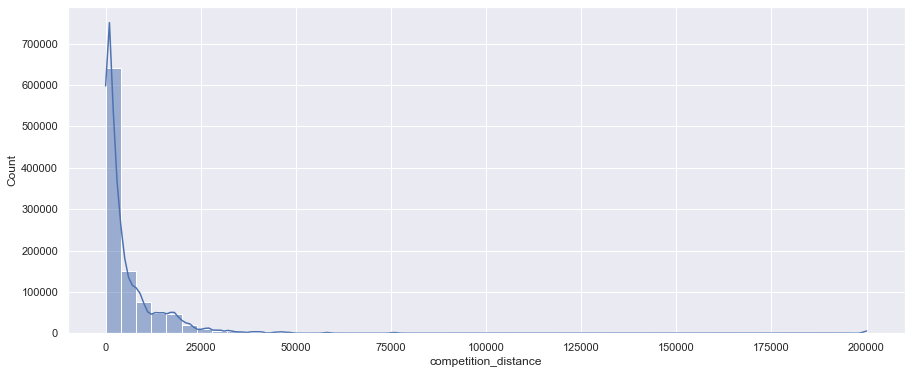

In [30]:
# verificando distribuição de distância dos concorrentes

plt.figure(figsize=(15, 6))
sns.histplot(df1['competition_distance'], bins=50, kde=True)

### Dados categóricos

In [31]:
# valores únicos dos dados categóricos
colunas_categoricas.apply(lambda x: x.unique().shape[0])

state_holiday                     4
store_type                        4
assortment                        3
competition_distance            655
competition_open_since_month     12
competition_open_since_year      23
promo2_since_week                52
promo2_since_year                 7
promo_interval                    4
month_map                        12
is_promo                          2
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

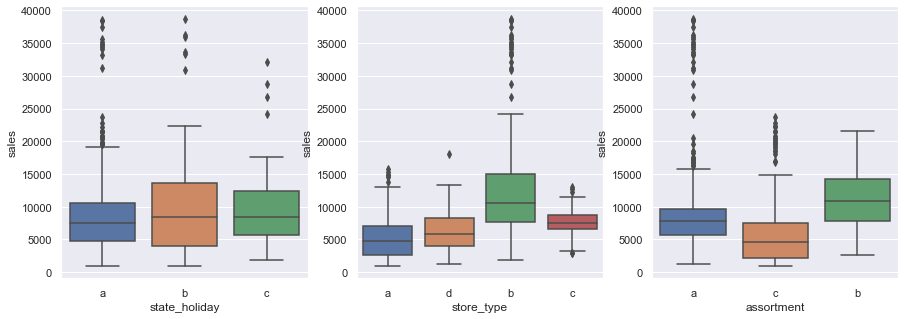

In [32]:
# criando um filtro de linhas
filtro = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# noção das vendas distribuídas nos níveis das variáveis categóricas

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=filtro)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=filtro)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=filtro)

In [33]:
# diminuindo tamanho do dataset

change_dtype(df1)

## 5.8 Detectando os agentes de impacto

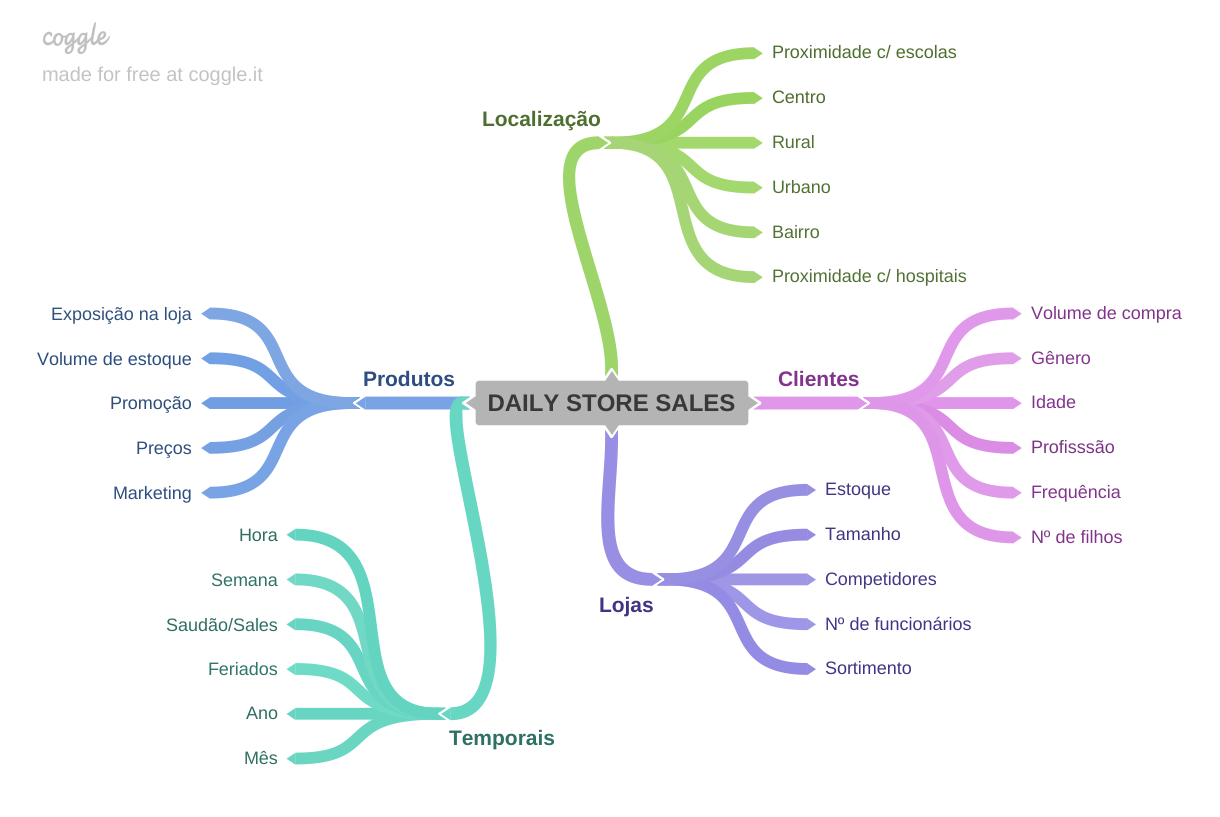

In [34]:
# Agentes de impacto nas vendas
Image("img/MindMapHypothesis.png")

## 5.9 Elaborando hipóteses

### 5.9.1 Hipóteses: Loja

**1.** Lojas com mais funcionários devem vender mais

**2.** Lojas com maior estoque devem vender mais

**3.** Lojas com maior porte devem vender mais

**4.** Lojas com maior sortimento devem vender mais

**5.** Lojas com competidores a mais tempo devem vender mais

### 5.9.2 Hipóteses: Produto

**1.** Lojas que investem mais em marketing devem vender mais

**2.** Lojas que expõem mais os produtos nas vitrines devem vender mais

**3.** Lojas que têm preços menores nos produtos devem vender mais

**4.** Lojas que têm preços menores por mais tempo nos produtos devem vender mais

**5.** Lojas com descontos maiores devem vender mais

**6.** Lojas com promoções ativas por mais tempo devem vender mais

**7.** Lojas com mais dias de promoção devem vender mais

**8.** Lojas com mais tipos de promoção consecutivas devem vender mais

### 5.9.3 Hipóteses: Tempo

**1.** Lojas que tem mais feriados devem vender menos

**2.** Lojas devem vender mais ao longo dos anos

**3.** Lojas devem vender mais no segundo semestre do ano

**4.** Lojas devem vender mais depois do dia 10 de cada mês

**5.** Lojas devem vender menos aos finais de semana

**6.** Lojas devem vender menos durante os feriados escolares

### 5.9.4 Lista final de hipóteses

OBS: foram priorizadas de acordo com o que possuía nos dados originais.

**1.** Lojas com maior sortimento devem vender mais
 
**2.** Lojas com competidores mais proximos devem vender menos
 
**3.** Lojas com competidores a mais tempo devem vender mais
 
**4.** Lojas com promoções ativas por mais tempo devem vender mais
 
**5.** Lojas com mais dias de promoção deveam vender mais
 
**6.** Lojas com mais promoções consecutivas devem vender mais
 
**7.** Lojas abertas durante o feriado de natal devem vender mais
 
**8.** Lojas devem vender mais ao longo dos anos
 
**9.** Lojas devem vender mais no segundo semestre do ano

**10.** Lojas devem vender mais depois do dia 10 de cada mês

**11.** Lojas devem vender menos nos finais de semana

**12.** Lojas devem vender menos durante os feriados escolares

# 6. Features engineering

In [35]:
# cópia do dataset
df2 = df1.copy()

In [36]:
# year
df2['year'] = df1['date'].dt.year

# month
df2['month'] = df1['date'].dt.month

# day
df2['day'] = df1['date'].dt.day

# week of year
df2['week_of_year'] = df1['date'].dt.isocalendar().week

# year week
df2['year_week'] = df1['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                 month=x['competition_open_since_month'],
                                                                 day=1), axis=1)

df2['competition_time_month'] = (
    (df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int32')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(
    x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = (
    (df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype('int32')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                                      'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else
                                                            'easter_holiday' if x == 'b' else
                                                            'chrismas' if x == 'c' else 'regular_day')

In [37]:
# diminuindo tamanho do dataset

change_dtype(df2)

# 7. Filtragem de variáveis

In [38]:
# cópia do dataset
df3 = df2.copy()

## 7.1 Filtragem das linhas

In [39]:
# apenas linhas com a loja aberta e com as vendas maiores que zero
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 7.2 Filtragem das colunas

In [40]:
# deletando as colunas
drop_colunas = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(drop_colunas, axis=1)

In [41]:
# checando as colunas do dataset
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [42]:
# diminuindo tamanho do dataset

change_dtype(df3)

# 8. Análise exploratória de dados (EDA)

In [43]:
df4 = df3.copy()

## 8.1 Análise univariada

### 8.1.1 Análise univariada da variável resposta

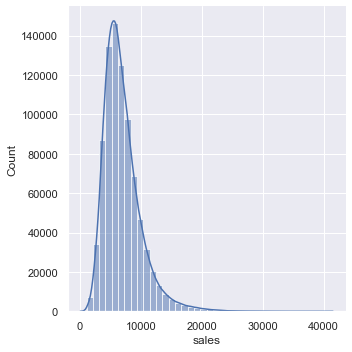

In [44]:
# distribuição da variável resposta

sns.displot(df4['sales'], bins=40, kde=True)

### 8.1.2 Variáveis numéricas

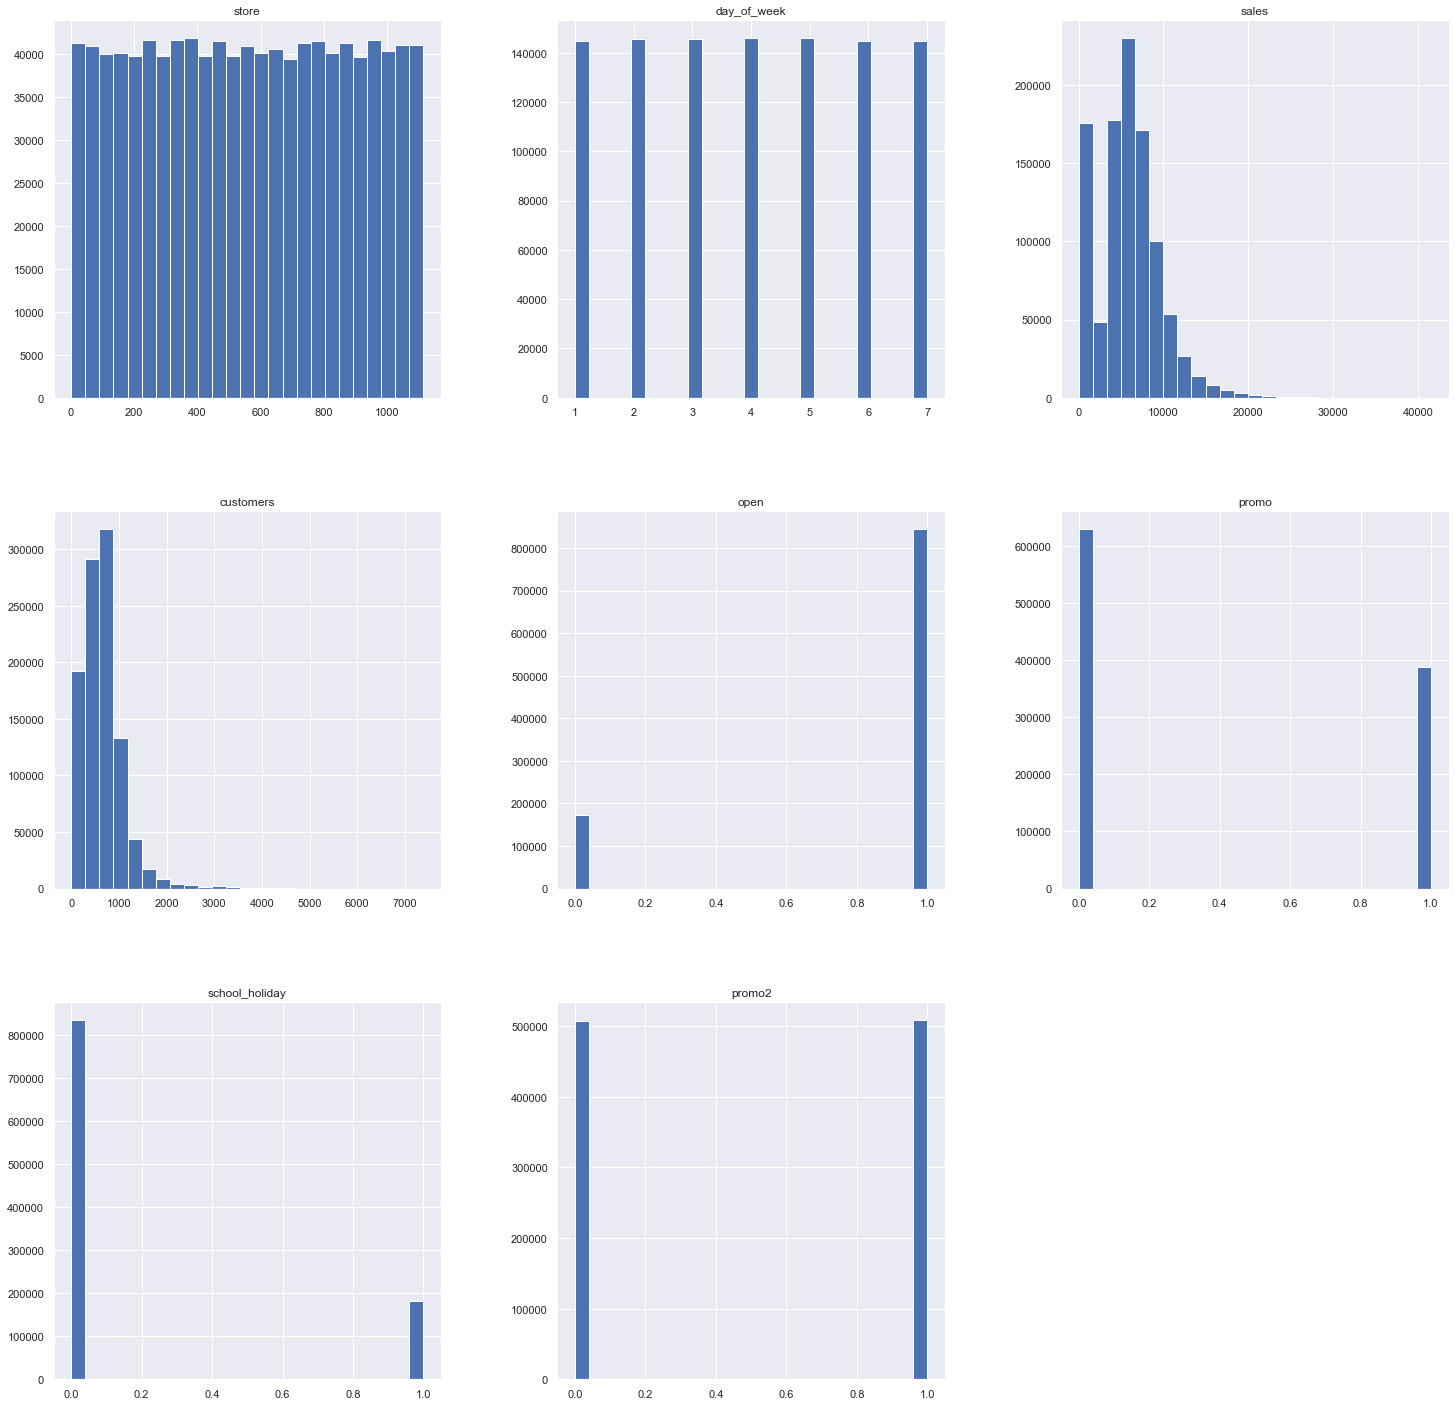

In [45]:
# checando as distribuições das variáveis numéricas

colunas_numericas.hist(figsize=(25, 25), bins=25);

**Análise das variáveis numéricas**

`competition_distance`: concentração maior de competidores na menor distância, ou seja, os competidores estão muito próximos

`competition_open_since_month`: os meses: 4, 9 e 11 foram os que mais abriram competidores próximos

`is_promo`: têm muito mais dias sem promoção


Variáveis sem variação:

- 'store'  
- 'day_of_week'  
- 'promo2'  

### 8.1.3 Variáveis categóricas

In [46]:
# checando categorias da coluna 'state_holiday'

df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'chrismas'],
      dtype=object)

In [47]:
# checando categorias da coluna 'story_type'

df4['store_type'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [48]:
# checando categorias da coluna 'story_type'

df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

<AxesSubplot: xlabel='sales', ylabel='Density'>

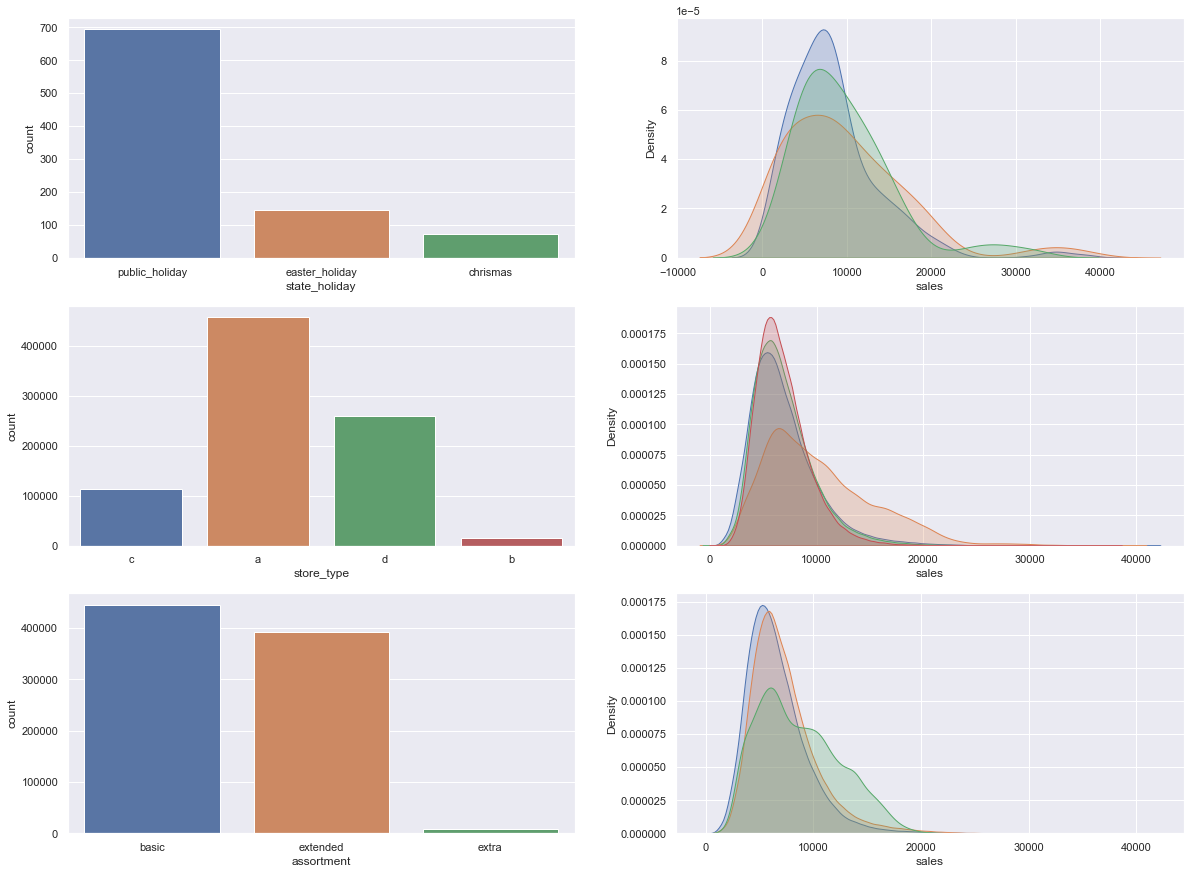

In [49]:
# 1. state_holiday

plt.figure(figsize=(20, 15))

plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']  # filtro
sns.countplot(x='state_holiday', data=a)


plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],
            label='public_holiday', fill=True)

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],
            label='easter_holiday', fill=True)

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'chrismas']['sales'],
            label='chrismas', fill=True)

# 2. store_type

plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],
            label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],
            label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],
            label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],
            label='d', fill=True)


# 3. assortment

plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],
            label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],
            label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],
            label='extra', fill=True)

## 8.2 Análise bivariada

Hipótese 1: Lojas com maior sortimento devem vender mais - **FALSA**

As lojas com maior sortimento venderam menos.

<AxesSubplot: xlabel='year_week'>

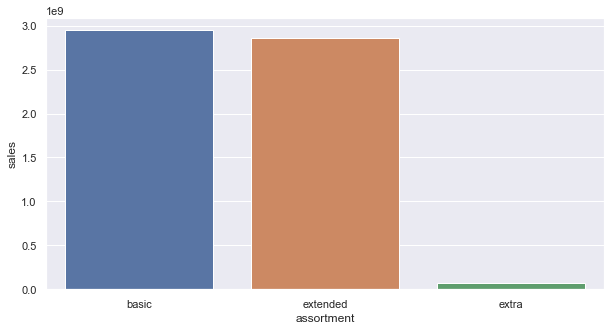

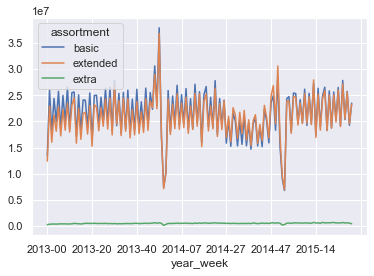

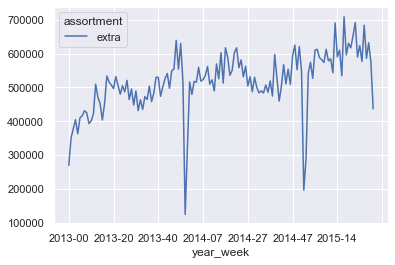

In [50]:
plt.figure(figsize=(10, 5))

# 1. comparando a soma das vendas por tipo de sortimento

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)


# 2. mostrando a variação das vendas por sortimento ao longo dos anos

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(
    ['year_week', 'assortment']).sum().reset_index()

aux2.pivot(index='year_week', columns='assortment', values='sales').plot()


# 3. mostrando variação das vendas quando o sortimento é 'extra'

aux3 = aux2[aux2['assortment'] == 'extra']  # maior sortimento
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

Hipótese 2: Lojas com competidores mais proximos devem vender menos - **FALSA**

As lojas com competidores mais próximos venderam mais.

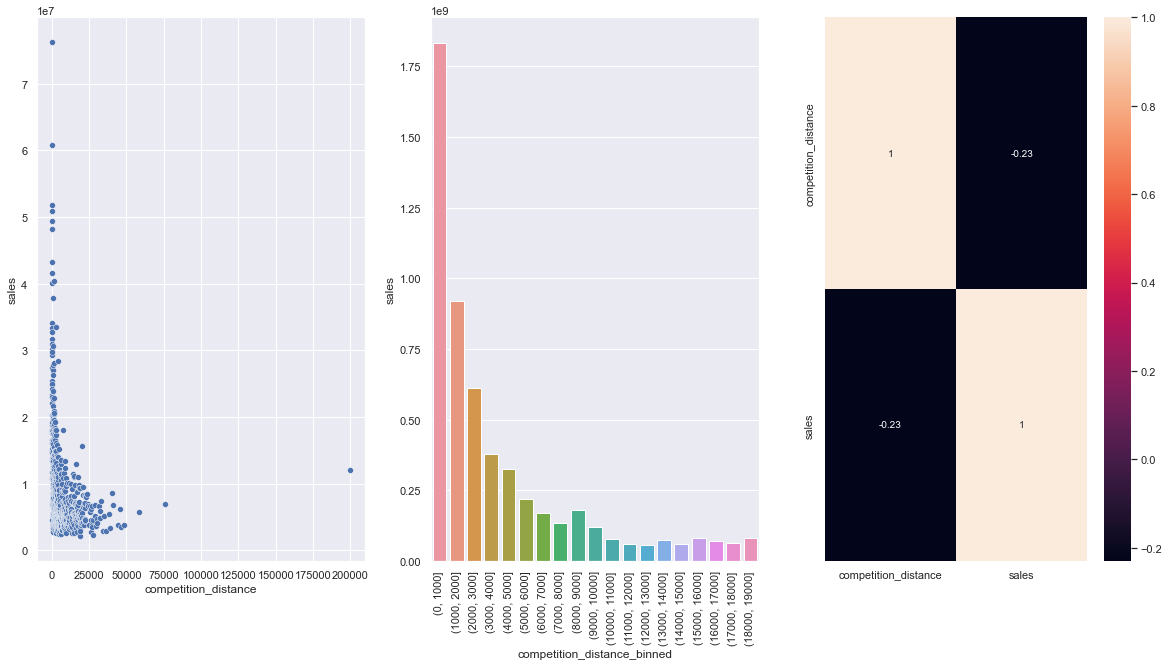

In [126]:
plt.figure(figsize=(20, 10))

# 1. verificar a distribuição das vendas em relação a distancia do competidor

aux1 = df4[['competition_distance', 'sales']].groupby(
    'competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

# 2. compararando o somatório de vendas por conjunto de competidores

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(
    aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby(
    'competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

# 3. correlação entre o valor de vendas, distância entre a loja e o competidor mais próximos

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)

Hipótese 3: Lojas com competidores a mais tempo devem vender mais - **FALSA**

As lojas com competidores a mais tempo venderam menos.

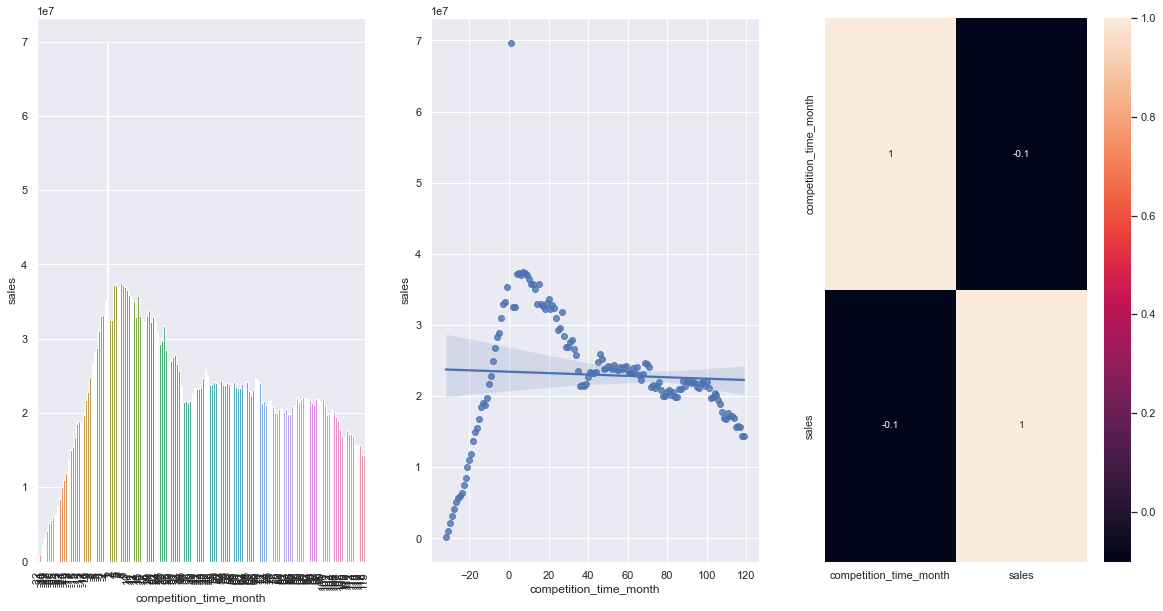

In [127]:
plt.figure(figsize=(20, 10))

# 1. comparando as vendas conforme os competidores abriam e iniciavam a competição

plt.subplot(1, 3, 1)

aux1 = df4[['competition_time_month', 'sales']].groupby(
    'competition_time_month').sum().reset_index()

# 1.1 filtrando os 120 primeiros meses de competição e tempo de competição diferente de zero
aux2 = aux1[(aux1['competition_time_month'] < 120) &
            (aux1['competition_time_month'] != 0)]


# 1.2 gráfico de barras
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

# 2. gráfico de tendência

# obs: tendência de crescimento das vendas em relação ao tempo de competição

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

# 3. correlação entre o tempo decorrido de competição com o valor das vendas

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)

`Observações`

- 'competition_time_month' foi derivada da coluna 'date' (datas de vendas da Rossmann) e da coluna 'competition_since' (data que o competidor abriu)


- Ou seja, ela representa a diferença em meses da data de venda registrada (Rossmann) da data que o competidor abriu (há quantos meses o competidor está ali)


- Valores positivos: o competidor ja existia no local quando a Rossmann iniciou as vendas


- Valores negativos: o competidor abriu depois de a loja da Rossmann ja ter iniciado suas vendas



- Quanto mais o tempo de competição aumenta, mais as vendas da Rossmann vão caindo

`Importante`

- O compartamento das vendas tanto decai quanto sobe ao longo do tempo


- O gráfico abaixo é de tendência linear e o comportamento das vendas não é linear, ou seja, esse gráfico não deve ser utilizado para gerar qualquer tipo de conclusão, e sim, somente para auxiliar na leitura do comportamento geral e entendimento de outros gráficos

Hipótese 4: Lojas com promoções ativas por mais tempo devem vender mais - **FALSA**

As lojas com promoções ativas por mais tempo venderam menos.

<AxesSubplot: >

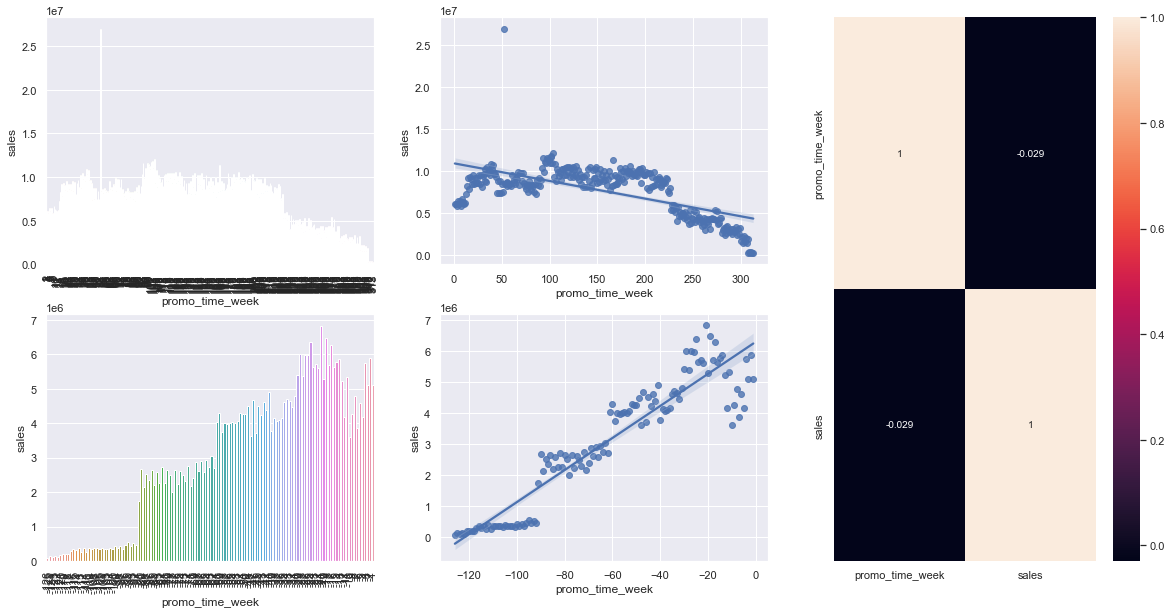

In [125]:
aux1 = df4[['promo_time_week', 'sales']].groupby(
    'promo_time_week').sum().reset_index()

plt.figure(figsize=(20, 10))

# definindo duas linhas e três colunas

grid = gridspec.GridSpec(2, 3)

# 1. vendas com relação ao período de promoção extendida

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

# 1.1 verificando se tendência das vendas é crescente ou descrescente
plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)


# 2. vendas com relação ao período de promoção regular

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

# 2.1 verificando se tendência das vendas é crescente ou descrescente

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)


# 3. verificando a correlação entre o tempo de promoção extendida e a quantiade de vendas
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

`Observações`

- promo_time_week: quanto tempo faz que uma promoção foi ativa


- período de promoção tradicional (promo) e extendido (promo2: quando a tradicional acaba)


- promo2_since_week: semana em que a promoção extendida começou (fim da tradicional)


- promo2_since_year: ano em que a promoção extendida começou (fim da tradicional)


- Para calcular o tempo em que a promoção ativa foi feita, foi utilizada a coluna 'date' (a data em que a promoção extendida começou, ou seja, o fim da tradicional)

- Isso tem dois resultados: positivo e negativo


- Positivo: a venda foi realizada no período promocional extendido


- Negativo: a venda no período tradicional de promoções

Hipótese 6: Lojas com mais promoções consecutivas devem vender mais - **FALSA**

As lojas com mais promoções consecutivas venderam menos.

In [54]:
# quantidade descrescente de vendas de acordo com o período de promoções

df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum(
).reset_index().sort_values(by='sales', ascending=True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


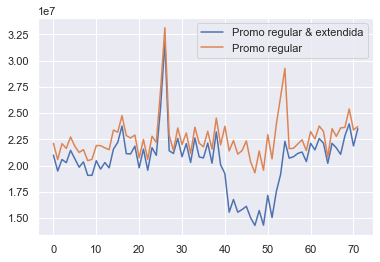

In [55]:
# verificando o comportamento das vendas quando a loja está em promoção extendida

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][[
    'year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# verificando o comportamento das vendas quando a loja está apenas em promoção regular

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][[
    'year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

# adicionando legendas

ax.legend(labels=['Promo regular & extendida', 'Promo regular'])

Hipótese 7: Lojas abertas durante o feriado de natal devem vender mais - **FALSA**

As lojas abertas durante o feriado de natal venderam menos.

<AxesSubplot: xlabel='year', ylabel='sales'>

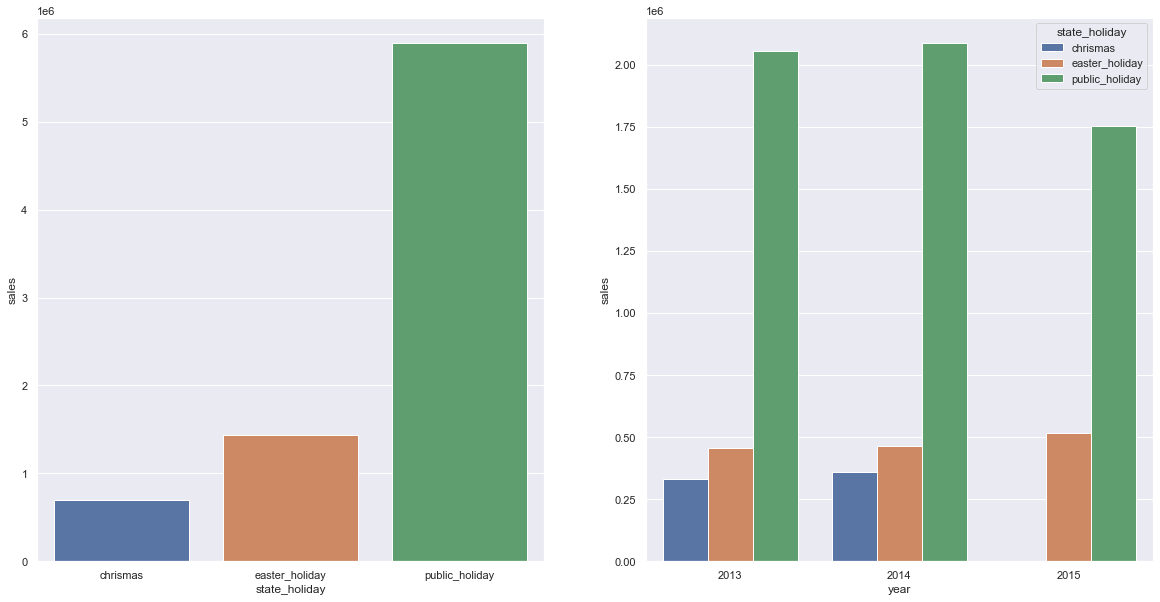

In [124]:
plt.figure(figsize=(20, 10))

# 1.filtro removendo os dias regulares (sem feriados)

plt.subplot(1, 2, 1)

aux = df4[df4['state_holiday'] != 'regular_day']

# 1.1 checando vendas ao longo dos feriados

aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum(
).reset_index()

sns.barplot(x='state_holiday', y='sales', data=aux1)


# 2. checando venda dos feriados ao longo do tempo

plt.subplot(1, 2, 2)

aux2 = aux[['year', 'state_holiday', 'sales']].groupby(
    ['year', 'state_holiday']).sum().reset_index()

sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

Hipótese 8: Lojas devem vender mais ao longo dos anos - **FALSA**  

As lojas venderam menos ao longo dos anos.

`Observação`: Só tem dados de 2015 até o mês de agosto.

<AxesSubplot: >

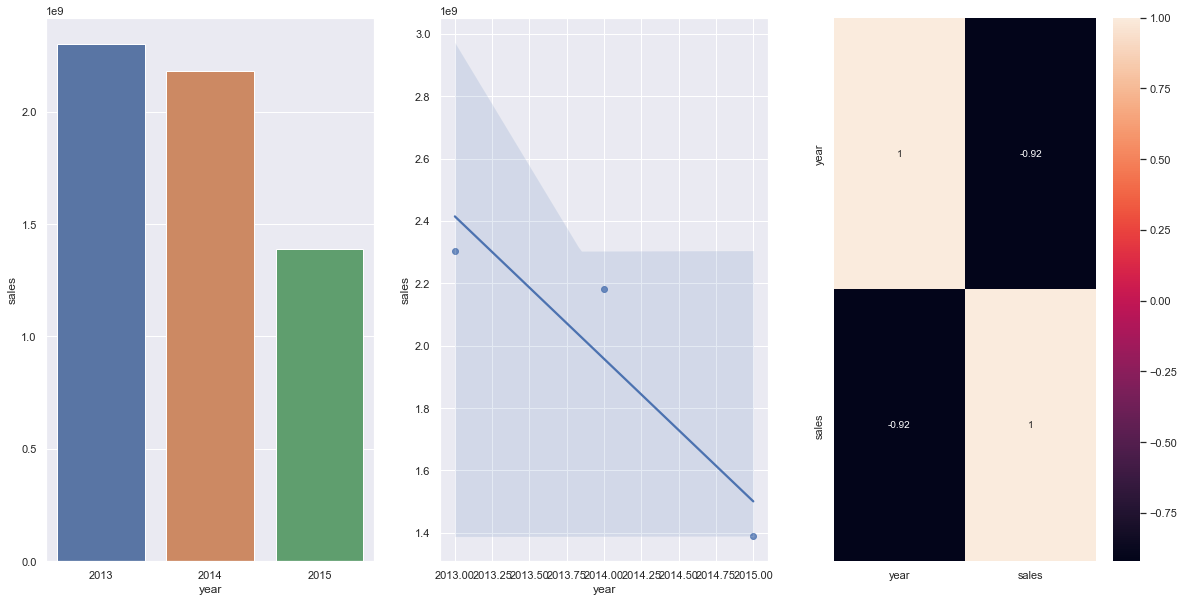

In [123]:
plt.figure(figsize=(20, 10))

# 1. checando vendas ao longo dos anos

plt.subplot(1, 3, 1)

aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

sns.barplot(x='year', y='sales', data=aux1)

# 2. checando tendência

plt.subplot(1, 3, 2)

sns.regplot(x='year', y='sales', data=aux1)

# 3. correlação

plt.subplot(1, 3, 3)

sns.heatmap(aux1.corr(method='pearson'), annot=True)

Hipótese 9: Lojas devem vender mais no segundo semestre do ano - **FALSA**

As lojas venderam menos no segundo semestre do ano.

<AxesSubplot: >

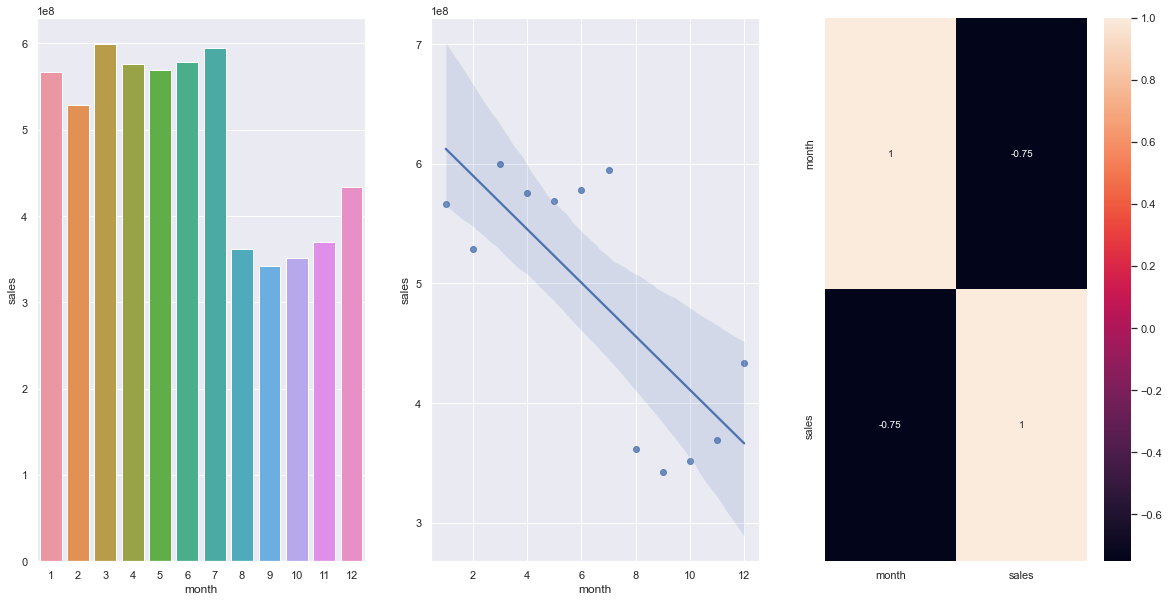

In [122]:
plt.figure(figsize=(20, 10))

# 1. checando vendas ao longo dos meses

plt.subplot(1, 3, 1)

aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

sns.barplot(x='month', y='sales', data=aux1)

# 2. checando tendência

plt.subplot(1, 3, 2)

sns.regplot(x='month', y='sales', data=aux1)

# 3. correlação

plt.subplot(1, 3, 3)

sns.heatmap(aux1.corr(method='pearson'), annot=True)

Hipótese 10: Lojas devem vender mais depois do dia 10 de cada mês - **VERDADEIRA**

As lojas venderam mais depois do dia 10 de cada mês.

<AxesSubplot: xlabel='before_after', ylabel='sales'>

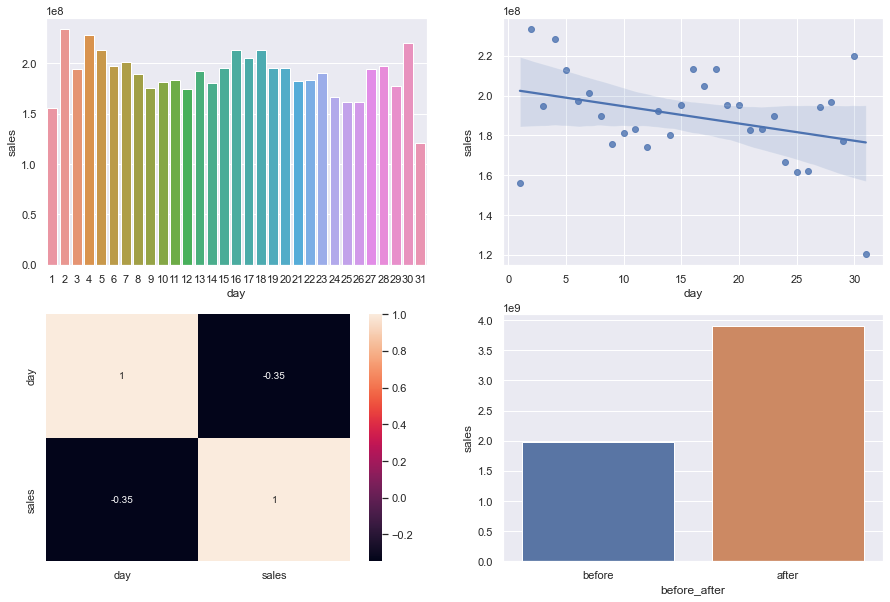

In [59]:
plt.figure(figsize=(15, 10))

# 1. checando vendas ao longo dos dias

plt.subplot(2, 2, 1)

aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

sns.barplot(x='day', y='sales', data=aux1)

# 2. checando tendência

plt.subplot(2, 2, 2)

sns.regplot(x='day', y='sales', data=aux1)

# 3. correlação

plt.subplot(2, 2, 3)

sns.heatmap(aux1.corr(method='pearson'), annot=True)

# 4. filtrando uma nova coluna para separar os dias antes e depois do dia 10

aux1['before_after'] = aux1['day'].apply(
    lambda x: 'before' if x <= 10 else 'after')

aux2 = aux1[['before_after', 'sales']].groupby(
    'before_after').sum().reset_index().sort_values(by='sales', ascending=True)

# 4.1 comparando as vendas antes e depois do dia 10

plt.subplot(2, 2, 4)

sns.barplot(x='before_after', y='sales', data=aux2)

Hipótese 11: Lojas devem vender menos nos finais de semana - **VERDADEIRA**

As lojas venderam menos nos finais de semana.

<AxesSubplot: >

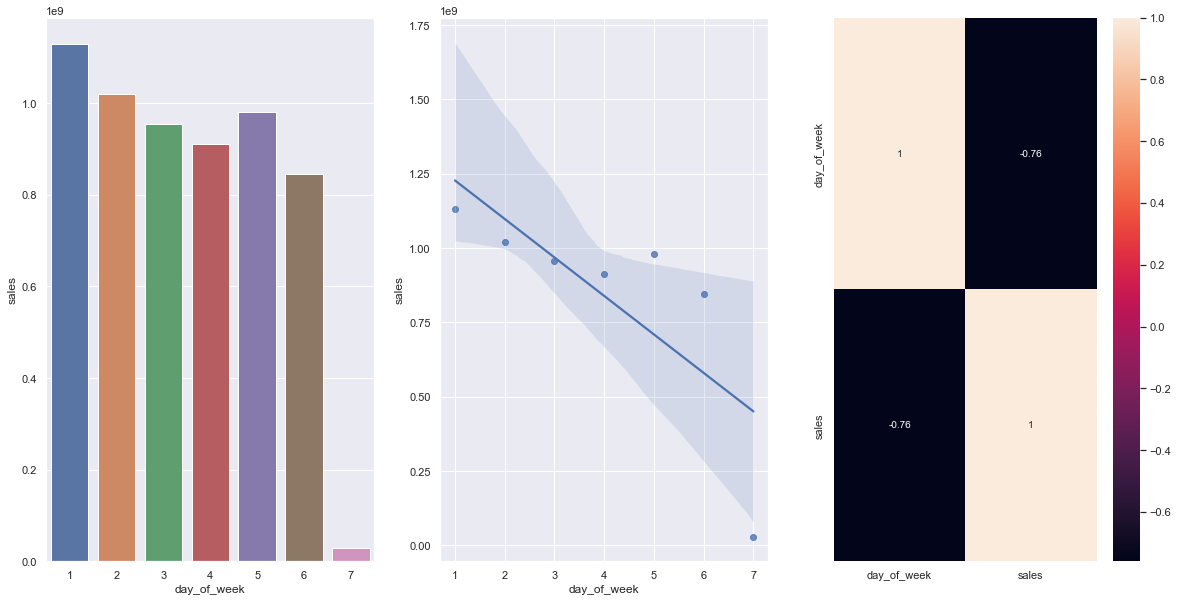

In [121]:
plt.figure(figsize=(20, 10))

# 1. checando dias da semana em relação as vendas

plt.subplot(1, 3, 1)

aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

sns.barplot(x='day_of_week', y='sales', data=aux1)

# 2. checando tendência

plt.subplot(1, 3, 2)

sns.regplot(x='day_of_week', y='sales', data=aux1)

# 3. correlação

plt.subplot(1, 3, 3)

sns.heatmap(aux1.corr(method='pearson'), annot=True)

Hipótese 12: Lojas devem vender menos durante os feriados escolares - **VERDADEIRA**

As lojas venderam menos durante os feriados escolares (exceto em Julho e Agosto).

<AxesSubplot: xlabel='month', ylabel='sales'>

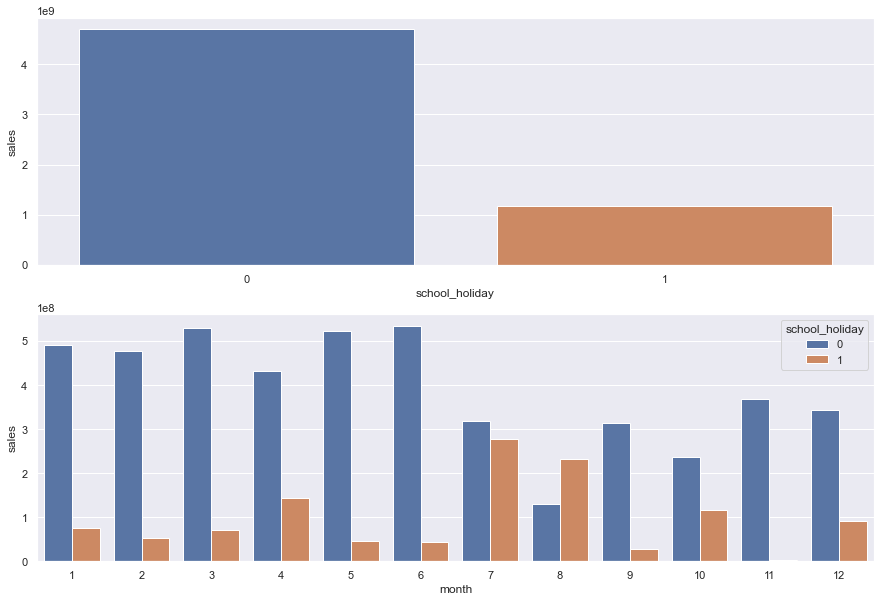

In [61]:
plt.figure(figsize=(15, 10))

# 1. verificando o valor de vendas entre os dias normais e feriados escolares

plt.subplot(2, 1, 1)

aux1 = df4[['school_holiday', 'sales']].groupby(
    'school_holiday').sum().reset_index()

sns.barplot(x='school_holiday', y='sales', data=aux1)

# 2. verificando o valor de vendas entre os dias normais e feriados escolares ao longo do mês

plt.subplot(2, 1, 2)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(
    ['month', 'school_holiday']).sum().reset_index()

sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

In [62]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]  
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 8.3 Análise multivariada

### 8.3.1 Atributos numéricos

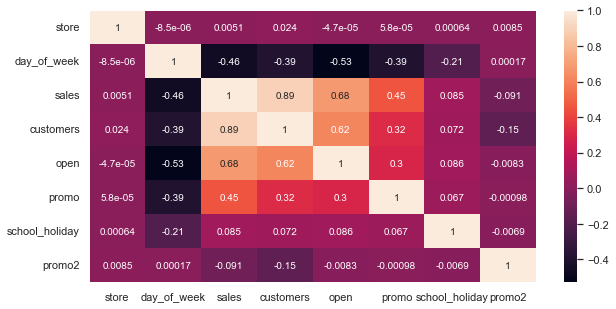

In [118]:
# analisando a correlação de dados numéricos

plt.figure(figsize=(10, 5))

correlacao_numericos = colunas_numericas.corr()

sns.heatmap(correlacao_numericos, annot=True)

plt.show()

### 8.3.2 Atributos categóricos

In [64]:
# selecionando somente dados categóricos

cat = df4.select_dtypes(include='object')

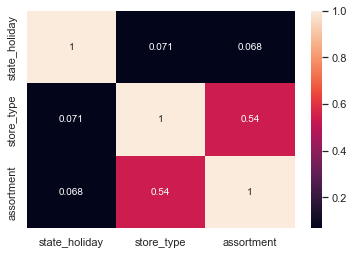

In [116]:
# aplicando a função de Cramer v para analisar a correlação dos dados

result_1 = cramer_v(cat['state_holiday'], cat['state_holiday'])
result_2 = cramer_v(cat['state_holiday'], cat['store_type'])
result_3 = cramer_v(cat['state_holiday'], cat['assortment'])

result_4 = cramer_v(cat['store_type'], cat['state_holiday'])
result_5 = cramer_v(cat['store_type'], cat['store_type'])
result_6 = cramer_v(cat['store_type'], cat['assortment'])

result_7 = cramer_v(cat['assortment'], cat['state_holiday'])
result_8 = cramer_v(cat['assortment'], cat['store_type'])
result_9 = cramer_v(cat['assortment'], cat['assortment'])


# salvando em um dataset

tab_cramerv = pd.DataFrame({'state_holiday': [result_1, result_2, result_3],
                            'store_type': [result_4, result_5, result_6],
                            'assortment': [result_7, result_8, result_9]})


tab_cramerv = tab_cramerv.set_index(tab_cramerv.columns)


# verificando a correlação entre as variáveis categóricas

sns.heatmap(tab_cramerv, annot=True)

plt.show()

In [66]:
# diminuindo tamanho do dataset

change_dtype(df4)

# 7. Preparação dos dados (Data Preparation)

In [67]:
df5 = df4.copy()

## 7.1 Normalização

Após a observação das variáveis numéricas da EDA (9.1.2), foi visto que não há nenhuma variável com distribuição normal (Gaussiana). Por esse motivo, não será feita a etapa de normalização dessas variáveis. Em contrapartida, será feita a etapa de Rescaling, que é mais adequada para dados com distribuição não Gaussiana.

## 7.2 Rescaling

Foi utilizado o boxplot para ver a possibilidade de usar o Robust Scaler.


Variáveis com natureza linear:

- competition_distance
- year
- competition_time_month
- promo_time_week

In [68]:
r = df5.select_dtypes(include=['int16', 'float32'])

- Checando outliers da coluna 'competition_distance' para ver se é necessário aplicar o RobustScaler

- Nas que não possuíam, foi usado o MinMaxScaler

In [69]:
# sns.boxplot(df5['competition_distance'])

# sns.boxplot(df5['year'])

# sns.boxplot(df5['competition_time_month'])

# sns.boxplot(df5['promo_time_week'])

In [70]:
rs = RobustScaler()

# 'competition_distance'
df5['competition_distance'] = rs.fit_transform(
    df5[['competition_distance']].values)

# 'competition_time_month'
df5['competition_time_month'] = rs.fit_transform(
    df5[['competition_time_month']].values)

mms = MinMaxScaler()

# 'promo_time_week'
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# 'year'
df5['year'] = mms.fit_transform(df5[['year']].values)

## 7.3 Transformação

### 7.3.1 Encoding

**Variáveis categóricas**

`state_holiday` ➞ _one hot encoding_  
 
 cria +4 colunas com as informações abaixo:  
- 'regular_day', 'public_holiday', 'easter_holiday', 'chrismas'  
         1 = True, 0 = False
         
         
`store_type` ➞ _label encoding_  
- substitui os itens abaixo em números:
         a, b, c, d ➞  1, 2, 3 e 4
        
        
`assortment` ➞ ordinal encoding  
- substitui os itens abaixo em números (ordinal)
        basic, extra e extended ➞ 1, 2, 3

In [71]:
# state_holiday

df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment

assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 7.3.2 Transformação da variável resposta

Aplicando uma transformação logarítmica à variável resposta, alterando a escala de valores para tratar a assimetria. Com essa mudança, valores menores serão reduzidos mais do que valores maiores, o que pode ajudar a diminuir a discrepância entre os valores extremos e os valores médios, levando a uma distribuição mais simétrica (normal).

<AxesSubplot: xlabel='sales', ylabel='Count'>

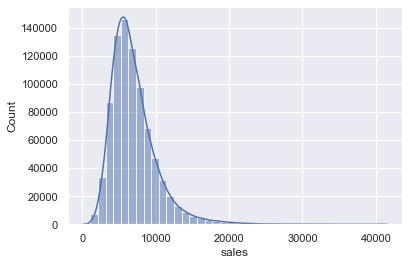

In [72]:
# verificando assimetria na distribuição dedados

sns.histplot(df5['sales'], bins=40, kde=True)

In [73]:
# transformando em log

df5['sales'] = np.log1p(df5['sales'])

<AxesSubplot: xlabel='sales', ylabel='Count'>

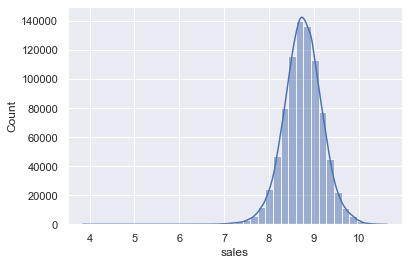

In [74]:
# distribuição mais normal

sns.histplot(df5['sales'], bins=40, kde=True)

### 7.3.3 Transformação de natureza

**Variáveis de natureza cíclica:**

- day
- day_of_week
- month
- week_of_year

In [75]:
# day

df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

# day_of_week

df5['day_of_week_sin'] = df5['day_of_week'].apply(
    lambda x: np.sin(x * (2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(
    lambda x: np.cos(x * (2 * np.pi / 7)))

# month

df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# week_of_year

df5['week_of_year_sin'] = df5['week_of_year'].apply(
    lambda x: np.sin(x * (2 * np.pi / 12)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(
    lambda x: np.cos(x * (2 * np.pi / 12)))

In [76]:
# diminuindo tamanho do dataset

change_dtype(df5)

# 8. Seleção de Features (Features selection)

In [77]:
df6 = df5.copy()

In [78]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_sin,day_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.5,-0.866025
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.5,-0.866025
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.5,-0.866025
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.5,-0.866025
4,5,5,2015-07-31,8.481152,1,1,0,1,4.448387,4,...,0,1,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.5,-0.866025


## 8.1 Split do dataset original em treino e teste

In [79]:
# quando colunas são derivadas de uma variável, a variável original deve ser apagada

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week',
             'promo_since', 'competition_since', 'year_week']

df6 = df6.drop(cols_drop, axis=1)

In [80]:
# verificando a data do primeiro dia das últimas 6 semanas (6 semanas * 7 dias = 42 dias)

df6[['store', 'date']].groupby('store').max().reset_index()[
    'date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [81]:
# diminuindo tamanho do dataset

change_dtype(df6)

`Observação`: como trata-se de um projeto de séries temporais, as linhas de treino e de teste não podem ser selecionadas aleatoriamente, pois podem estar dando dados futuros e passados para o modelo.

`Dados de treino`: todas as datas antes de 19/06/2015


`Dados de teste`: todas as datas iguais ou após o dia 19/06/2015 (6 últimas semanas)

Update: para fins de organizações futuras, a princípio os datasetes abaixo não estão na forma final de treino e teste, apenas estão separados pelas datas.Os dados de treino e de teste foram divididos posteriormente.

In [82]:
# separando features e target

# treino
features_train = df6[df6['date'] < '2015-06-19'] #obs: tem a coluna target
target_train = features_train['sales']

# teste
features_test = df6[df6['date'] >= '2015-06-19'] #obs: tem a coluna target
target_test = features_test['sales']

In [83]:
# verificando datas mínimas e máximas 

print(f'Data mínima de treino: {features_train["date"].min()}')
print(f'Data máxima de treino: {features_train["date"].max()}')

print(f'Data mínima de teste: {features_test["date"].min()}')
print(f'Data máxima de teste: {features_test["date"].max()}')

Data mínima de treino: 2013-01-01 00:00:00
Data máxima de treino: 2015-06-18 00:00:00
Data mínima de teste: 2015-06-19 00:00:00
Data máxima de teste: 2015-07-31 00:00:00


## 8.2 Implementação do algoritmo Boruta para a seleção de features

In [84]:
# diminuindo tamanho do dataset

change_dtype(features_train)

In [85]:
# separando os dados de treino para o boruta

X_train_n = features_train.drop(['date', 'sales'], axis=1).values
y_train_n = target_train.values.ravel()

In [86]:
# 1. definindo o Random Forest Regressor
rf = RandomForestRegressor()

In [87]:
# 2. definindo o boruta
boruta = BorutaPy(rf, n_estimators=10, verbose=2, random_state=42)

In [88]:
# 3. treinando o boruta
# boruta.fit(X_train_n, y_train_n)

# 4. salvando as colunas relevantes em uma lista
# cols_selecionadas = boruta.support_.tolist()

In [89]:
# X_train_fs = features_train.drop(['date'], axis=1)

# 5. melhores features do boruta
# colunas_boruta = X_train_fs.iloc[:,cols_selecionadas]

# 6. analisando quais colunas o boruta nao selecionou
# colunas_excluidas = np.setdiff1d(X_train_fs.columns,colunas_boruta.columns)

In [90]:
# 7. salvando as features

colunas_boruta = [
                'store',
                'promo',
                'store_type',
                'assortment',
                'competition_distance',
                'competition_open_since_month',
                'competition_open_since_year',
                'promo2',
                'promo2_since_week',
                'promo2_since_year',
                'competition_time_month',
                'promo_time_week',
                'day_of_week_sin',
                'day_of_week_cos',
                'month_sin',
                'month_cos',
                'day_sin',
                'day_cos',
                'week_of_year_sin',
                'week_of_year_cos']

# colunas para adicionar
add = ['date', 'sales']

# colunas finais para o modelo
todas_as_colunas =  colunas_boruta.copy()
todas_as_colunas.extend(add)


colunas_excluidas = ['is_promo', 'school_holiday', 'state_holiday_chrismas',
                    'state_holiday_easter_holiday', 'state_holiday_public_holiday',
                    'state_holiday_regular_day', 'year']

## 8.3 Definindo dados de treino e teste

In [91]:
X_train = features_train[colunas_boruta]
X_test = features_test[colunas_boruta]
y_train = target_train
y_test = target_test

# preparação para o cross-validation
x_training = features_train[todas_as_colunas]

# 9. Modelos de Machine learning

## 9.1 Average model

`Observação`

Foi utilizada a função exponencial np.expm1 para reverter o log feito na seção de "Transformação da variável resposta (7.3.2)", pois ao aplicar uma transformação logarítmica à variável resposta, é necessário reverter a transformação nos valores previstos pelo modelo para que eles possam ser interpretados na escala original.

In [92]:
# previsão com a média

aux1 = X_test.copy()
aux1['sales'] = y_test.copy()


# criando uma coluna 'predictions' correspondete à média de vendas das lojas

aux2 = aux1[['store', 'sales']].groupby('store').mean(
).reset_index().rename(columns={'sales': 'predictions'})

# juntando os datasets

aux1 = pd.merge(aux1, aux2, how='left', on='store')

y_pred_baseline = aux1['predictions']


# performance

baseline_result = ml_error('Avarege Model', np.expm1(
    y_test), np.expm1(y_pred_baseline))  # obs: func exponencial
baseline_result

,Model,MAE,MAPE,RMSE
0,Avarege Model,1354.800415,0.2064,1835.135498


## 9.2 Linear regression model

In [93]:
# treinamento

lr = LinearRegression()
lr.fit(X_train, y_train)

# previsão

y_pred_lr = lr.predict(X_test)

# performance

lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(y_pred_lr))
lr_result

,Model,MAE,MAPE,RMSE
0,Linear Regression,1873.000557,0.295634,2669.849328


## 9.3 Linear regression regularized model - Lasso

In [94]:
# treinamento

lrr = Lasso(alpha=0.01)
lrr.fit(X_train, y_train)

# previsão

y_pred_lrr = lrr.predict(X_test)

# performance

lrr_result = ml_error('Lasso',
                      np.expm1(y_test), np.expm1(y_pred_lrr))
lrr_result

,Model,MAE,MAPE,RMSE
0,Lasso,1891.704903,0.289106,2744.451751


## 9.4 Random Forest Regressor

In [95]:
# convertendo para um array do numpy

y_train = y_train.values

In [96]:
# treinamento

rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train.ravel())

# previsão

y_pred_rf = rf.predict(X_test)

# performance

rf_result = ml_error('Random Forest Regressor',
                     np.expm1(y_test), np.expm1(y_pred_rf))
rf_result

,Model,MAE,MAPE,RMSE
0,Random Forest Regressor,701.981456,0.104354,1040.183609


## 9.5 XGBoost Regressor

In [97]:
# treinamento

model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50,
                       eta=0.01, max_depth=10, subsample=0.7, colsample_bytree=0.9)

model_xgb.fit(X_train, y_train.ravel())

# previsão

y_pred_xgb = model_xgb.predict(X_test)

# performance

xgb_result = ml_error('XGBRegressor',
                      np.expm1(y_test), np.expm1(y_pred_xgb))
xgb_result

,Model,MAE,MAPE,RMSE
0,XGBRegressor,6953.010254,0.99304,7589.081543


## 9.6 Comparação de performances do modelo

In [98]:
result = pd.concat([baseline_result, lr_result,
                   lrr_result, rf_result, xgb_result])
result.sort_values(by='RMSE', ascending=True)

,Model,MAE,MAPE,RMSE
0,Random Forest Regressor,701.981456,0.104354,1040.183609
0,Avarege Model,1354.800415,0.206400,1835.135498
0,Linear Regression,1873.000557,0.295634,2669.849328
0,Lasso,1891.704903,0.289106,2744.451751
0,XGBRegressor,6953.010254,0.993040,7589.081543


`Observações`

- O erro RMSE do modelo de média (baseline) é menor que os modelos de regressão linear
- Ou seja, é provável que os dados possuam um comportamento não linear
- Sendo assim, os modelos lineares não conseguiram performar bem com essa base de dados.

# 10. Time Series Cross-validation 

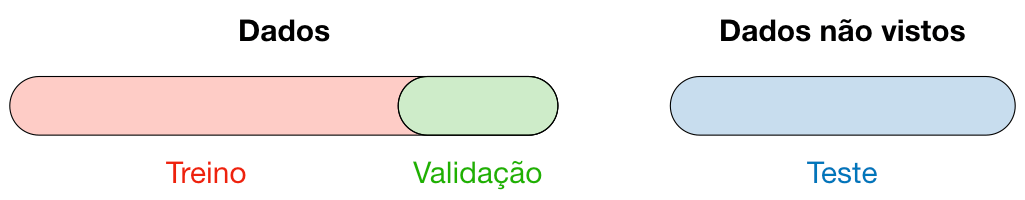

In [99]:
# separação dos dados para o cross-validation

Image("img/cross-validation.png", width=500)

`Observações`

- Os dados de treino foram separados em treino e validação (abaixo)

- Os dados de validação correspondem sempre às últimas 6 semanas do dataset

`treino`: datas anteriores as últimas 6 semanas

`validação`: colunas >= a data de início e <= a data de fim (últimas 6 semanas)

In [100]:
def cross_validation(x_training, kfold, model_name, model, verbose = False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):

        # acompanhando o algoritmo
        if verbose:
            print(f'Kfold number: {k}')
            
        # início e fim dos dados de validação
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtrando o dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # dados de treino
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # dados de validação
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # treinamento do modelo
        modelo = model.fit(xtraining, ytraining)

        # previsão
        y_pred = modelo.predict(xvalidation)

        # performance
        resultado_modelo = ml_error(model_name, np.expm1(yvalidation), np.expm1(y_pred))

        # guardando a performance para cada iteração do kfold
        mae_list.append(resultado_modelo['MAE'])
        mape_list.append(resultado_modelo['MAPE'])
        rmse_list.append(resultado_modelo['RMSE'])

    return pd.DataFrame({
        'Model': model_name,
        'MAE_CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE_CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE_CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])

## 10.1 Linear regression - Cross-validation

In [101]:
lr_result_cv = cross_validation(x_training, 3, 'Linear Regression', lr)
lr_result_cv

,Model,MAE_CV,MAPE_CV,RMSE_CV
0,Linear Regression,1947.71 +/- 107.53,0.29 +/- 0.01,2785.39 +/- 188.71


## 10.2 Lasso - Cross-validation

In [102]:
lrr_result_cv = cross_validation(x_training, 3, 'Lasso', lrr)
lrr_result_cv

,Model,MAE_CV,MAPE_CV,RMSE_CV
0,Lasso,1994.91 +/- 143.62,0.28 +/- 0.0,2895.12 +/- 232.31


## 10.3 Random Forest Regressor - Cross-validation

In [103]:
rf_result_cv = cross_validation(x_training, 3, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

Kfold number: 3
Kfold number: 2
Kfold number: 1


,Model,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor,706.17 +/- 124.69,0.1 +/- 0.01,1064.34 +/- 190.24


## 10.4 XGBoost Regressor - Cross-validation

In [104]:
xgb_result_cv = cross_validation(x_training, 3, 'XGBRegressor', model_xgb, verbose=True)
xgb_result_cv

Kfold number: 3
Kfold number: 2
Kfold number: 1


,Model,MAE_CV,MAPE_CV,RMSE_CV
0,XGBRegressor,7138.19 +/- 362.23,0.99 +/- 0.0,7762.74 +/- 416.88


## 10.5 Performance real - Cross-validation

In [105]:
# performance anterior

result.sort_values(by='RMSE', ascending=True)

,Model,MAE,MAPE,RMSE
0,Random Forest Regressor,701.981456,0.104354,1040.183609
0,Avarege Model,1354.800415,0.206400,1835.135498
0,Linear Regression,1873.000557,0.295634,2669.849328
0,Lasso,1891.704903,0.289106,2744.451751
0,XGBRegressor,6953.010254,0.993040,7589.081543


De acordo com os dados acima, o fenômeno do modelo pode ser considerado complexo, pois algoritmos lineares tiveram o pior desempenho (maior erro). No entanto, é necessário realizar o cross-validation para obter os resultados reais da performance do modelo.

In [106]:
# performance real - Cross-validation

result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
result_cv.sort_values(by='RMSE_CV', ascending=True)

,Model,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor,706.17 +/- 124.69,0.1 +/- 0.01,1064.34 +/- 190.24
0,Linear Regression,1947.71 +/- 107.53,0.29 +/- 0.01,2785.39 +/- 188.71
0,Lasso,1994.91 +/- 143.62,0.28 +/- 0.0,2895.12 +/- 232.31
0,XGBRegressor,7138.19 +/- 362.23,0.99 +/- 0.0,7762.74 +/- 416.88


O modelo de Random Forest Regressor apresentou o melhor desempenho, por esse motivo, foi escolhido como o modelo final.

# 11. Hyperparameter Fine tuning

## 11.1 Randomized Search CV 

In [ ]:
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV

In [133]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)

params_grid = {'n_estimators':[50, 100, 150], 
                'max_depth':np.arange(4, 21, 1, dtype=np.int),
                'min_samples_split': [2,5,10,30],
                'max_features': [1, 2, 5, 15, 20]
              }
forest_randcv = RandomizedSearchCV(rf, params_grid, n_iter=3, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
forest_randcv.fit(x_training)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END max_depth=20, max_features=5, min_samples_split=2, n_estimators=50; total time= 1.9min
[CV] END max_depth=20, max_features=5, min_samples_split=2, n_estimators=50; total time= 2.2min
[CV] END max_depth=17, max_features=15, min_samples_split=2, n_estimators=100; total time= 8.2min
[CV] END max_depth=12, max_features=15, min_samples_split=10, n_estimators=50; total time= 3.2min
[CV] END max_depth=12, max_features=15, min_samples_split=10, n_estimators=50; total time= 3.7min
[CV] END max_depth=20, max_features=5, min_samples_split=2, n_estimators=50; total time= 1.9min
[CV] END max_depth=17, max_features=15, min_samples_split=2, n_estimators=100; total time= 8.5min
[CV] END max_depth=17, max_features=15, min_samples_split=2, n_estimators=100; total time= 8.4min
[CV] END max_depth=12, max_features=15, min_samples_split=10, n_estimators=50; total time= 2.0min


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'max_depth': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                                        'max_features': [1, 2, 5, 15, 20],
                                        'min_samples_split': [2, 5, 10, 30],
                                        'n_estimators': [50, 100, 150]},
                   scoring='neg_mean_absolute_error', verbose=2)

RandomForestRegressor(max_depth=20, max_features=5, n_estimators=50, n_jobs=-1,
                      random_state=42).

# 12. Modelo final

In [141]:
model_rf_tuned = forest_randcv.best_estimator_

# predição
y_pred_rf_tuned = model_rf_tuned.predict(X_test)

# performance
rf_result_tuned = ml_error('RandomForest', np.expm1(y_test), np.expm1(y_pred_rf_tuned))
rf_result_tuned

,Model,MAE,MAPE,RMSE
0,RandomForest,930.037874,0.134554,1394.759364


In [144]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(y_pred_rf_tuned))
mpe

13.455416487101788

# 13. Tradução e interpretação do erro

Em média, as previsões do modelo estão desviando cerca de 10.97% do valor real.

In [145]:
df9 = features_test[todas_as_colunas]

Aplicando a função exponencial (reversa) para deixar na escala original.

In [146]:
# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1(y_pred_rf_tuned)

# 14. Performance de negócio

`Observações`

- O erro MAE corresponde a porcentagem de erro MAPE das vendas reais (em média) das lojas.
- As colunas abaixo significam:
        'predictions': quanto de receita a empresa fará  
        'best_scenario': melhor cenário, com erro MAE pra cima  
        'worst_scenario': pior cenário, com erro MAE para baixo

In [147]:
# soma das predições

df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()


# MAE e MAPE

df9_aux1 = df9[['store', 'sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns= {0:'MAE'})

df9_aux2 = df9[['store', 'sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns= {0:'MAPE'})

# merge MAE e MAPE

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how= 'inner', on= 'store')

df92 = pd.merge(df91, df9_aux3, how= 'inner', on= 'store')

# cenários

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [148]:
# visualizando dados dos maiores erros MAPE por loja

df92.sort_values('MAPE', ascending=False)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
434,435,190917.628722,188748.530826,193086.726617,2169.097895,0.743972
971,972,205341.138690,203055.080762,207627.196618,2286.057928,0.694031
285,286,219350.735052,217110.093376,221591.376728,2240.641676,0.672471
291,292,110932.905756,107476.787880,114389.023631,3456.117875,0.618349
424,425,182524.255395,180754.951208,184293.559581,1769.304187,0.579346
...,...,...,...,...,...,...
671,672,305013.781820,304534.800880,305492.762761,478.980941,0.057619
634,635,221070.717442,220761.860632,221379.574252,308.856810,0.054496
1096,1097,448221.448426,447692.550336,448750.346516,528.898090,0.048591
732,733,637553.245813,636888.205899,638218.285726,665.039914,0.046195


In [158]:
np.round(df92.sample(3),2)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
522,523,500501.69,499685.00,501318.38,816.69,0.06
1092,1093,285228.92,284254.73,286203.12,974.20,0.11
1047,1048,259014.26,258266.21,259762.32,748.05,0.09


`Importante`

A maioria das lojas estão por volta do erro de 10%. No entanto, há algumas lojas com erro alto, consideradas mais desafiadoras.

<AxesSubplot: xlabel='store', ylabel='MAPE'>

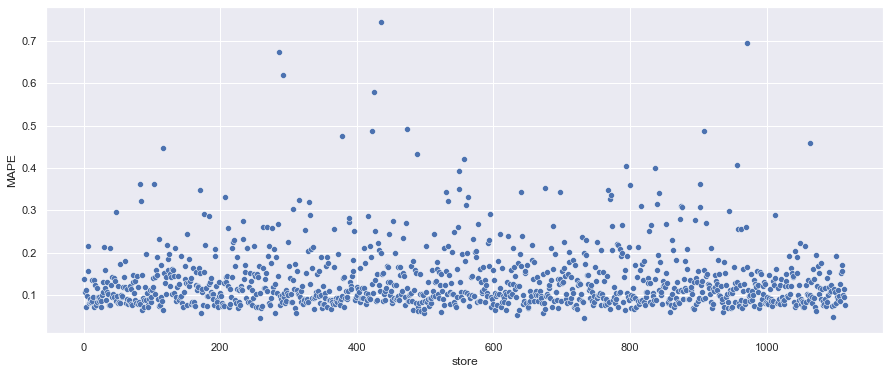

In [149]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='store', y='MAPE', data= df92)

## 14.1 Performance total e receita da empresa

In [150]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Cenários', 0:'Valores'} )
df93['Valores'] = df93['Valores'].map( 'R${:,.2f}'.format )
df93

,Cenários,Valores
0,predictions,"R$281,903,782.00"
1,worst_scenario,"R$280,864,313.58"
2,best_scenario,"R$282,943,250.43"


## 14.2 Performance de Machine learning

In [151]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot: xlabel='predictions', ylabel='error'>

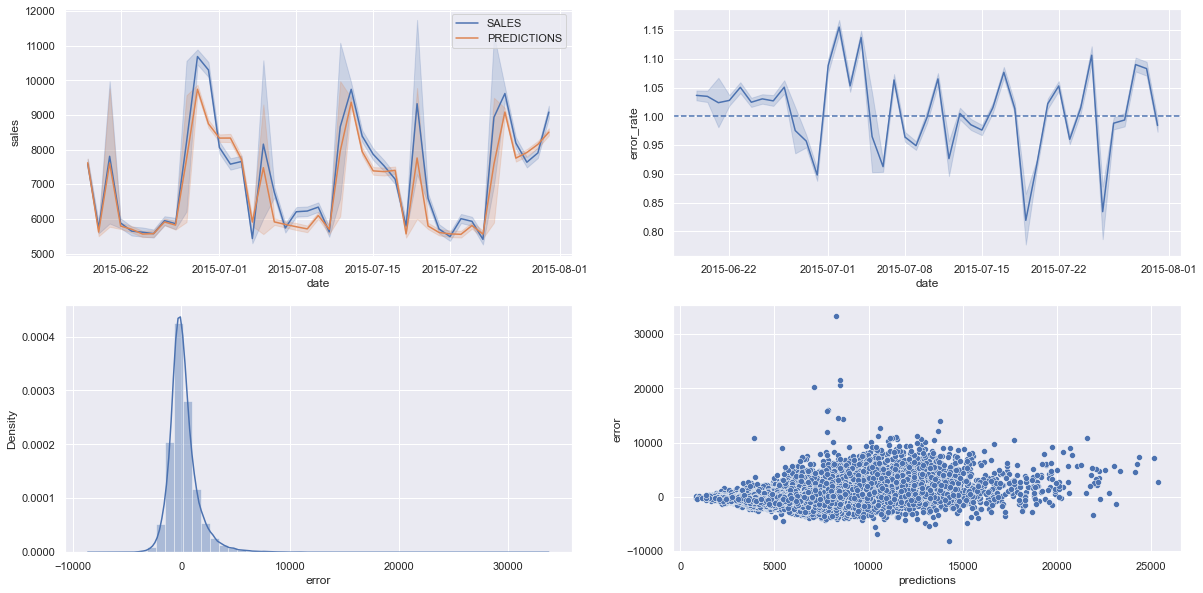

In [154]:
plt.figure(figsize=(20, 10))

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot(x=df9['predictions'], y=df9['error'])

# 15. Salvando o modelo

In [155]:
import joblib

joblib.dump(model_rf_tuned, 'model.pkl')

['model.pkl']